# **Project: Classify Waste Products Using Transfer Learning**


The manual sorting of waste is not only labor-intensive but also prone to errors, leading to contamination of recyclable materials. The goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving efficiency and reducing contamination rates. The project will use transfer learning with a pre-trained VGG16 model to classify images.


The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images. This can then be applied to real-world waste management processes.

Final Output model: A trained model that classifies waste images into recyclable and organic categories.



In this project, I have

- Applied transfer learning using the VGG16 model for image classification.
- Prepared and preprocessed image data for a machine learning task.
- Fine-tuned a pre-trained model to improve classification accuracy.
- Evaluated the model’s performance using appropriate metrics.
- Visualized model predictions on test data.

I have used the following libraries:

*   numpy  for mathematical operations.
*   sklearn for machine learning and machine-learning-pipeline related functions.
*   matplotlib for additional plotting tools.
*   tensorflow for machine learning and neural network related functions.


### Installed Required Libraries


In [3]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy==1.26.0 | tail -n 1
!pip install scikit-learn==1.5.1  | tail -n 1
!pip install matplotlib==3.9.2  | tail -n 1

### Imported Required Libraries


In [ ]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


## The version of tensorflow


In [5]:
# Task 1
print(tf.__version__)

2.17.0


## Background


**Transfer learning** uses the concept of keeping the early layers of a pre-trained network, and re-training the later layers on a specific dataset. You can leverage some state of that network on a related task.

A typical transfer learning workflow in Keras looks something like this:

1.  Initialize base model, and load pre-trained weights (e.g. ImageNet)
2.  "Freeze" layers in the base model by setting `training = False`
3.  Define a new model that goes on top of the output of the base model's layers.
4.  Train resulting model on your data set.

## Created a model for distinguishing recyclable and organic waste images

### Dataset

I have used the Waste Classification Dataset <br>
### URL <br>
https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01

I have trained an algorithm on these images and to predict the labels for images in the test set (1 = recyclable, 0 = organic).

### Importing Data

This creates a `o-vs-r-split` directory in the environment.


In [6]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        # labels each step as a file
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                # Increments the progress bar by 1
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [01:47<00:00, 11.24file/s]


Finished extracting file
Finished extracting file


### Defined configuration options

Model configuration options.

*   **batch size** is set to 32.
*   The **number of classes** is 2.
*   I've used 20% of the data for **validation** purposes.
*   I've kept two **labels** in your dataset: organic (O), recyclable (R).


In [7]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### Loaded Images using ImageGeneratorClass

Transfer learning works best when models are trained on smaller datasets. 

The folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```


#### ImageDataGenerators

I've created ImageDataGenerators used for training, validation and testing.

Image data generators create batches of tensor image data with real-time data augmentation. The generators loop over the data in batches and are useful in feeding data to the training process. 



In [ ]:
# Created ImageDataGenerators for training and validation and testing

#Specified val_split for both 
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    subset = 'training',
    batch_size = batch_size,
    target_size=(img_rows, img_cols),
    class_mode='binary',
    seed = seed,
    shuffle = True,
)

Found 800 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


## Created a `test_generator` using the `test_datagen` object

In [ ]:
# A `test_generator` using the `test_datagen` object

test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    batch_size=batch_size,
    target_size = (img_rows, img_cols),
    class_mode = 'binary',
    shuffle = False,
    seed = seed
        
)


Found 200 images belonging to 2 classes.


## The length of the `train_generator'

In [12]:
# Task 3: print the length of the `train_generator`
print(len(train_generator))

25


A few augmented images:


Labels: ['O', 'O', 'O', 'O', 'O']


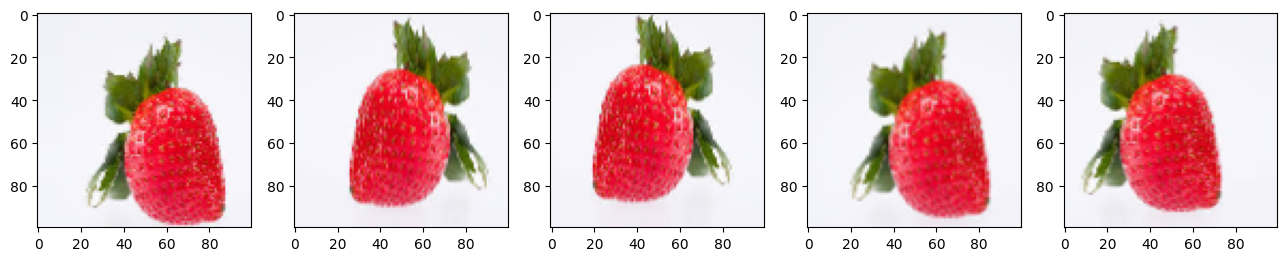

In [13]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### Pre-trained Models

Pre-trained models are saved networks that have previously been trained on some large datasets. They are typically used for large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.

#### VGG-16

I've loaded the VGG16 model.


In [14]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I've flattened the output of a vgg model and assigned it to the model `output`, and then used a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [15]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, I've freezed the basemodel.


In [16]:
for layer in basemodel.layers: 
    layer.trainable = False

Created a new model on top. I've added Dropout layers for regularization, only these layers will change. For the lower layers I've set `training=False` when calling the base model.


In [17]:
# output_shape (batch_size, num_of_features)
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## The summary of the model

In [ ]:
# Printed the summary of the model
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


## Compiled the model

In [ ]:
# Compiled the model
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(learning_rate=1e-4),
    metrics = ['accuracy']
)


I've used early stopping to avoid over-training the model.


In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## Fitted and trained the model


In [21]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10
lr: 9.048374180359596e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4902 - loss: 0.7350 
5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 15s/step - accuracy: 0.5500 - loss: 0.6838 - val_accuracy: 0.6198 - val_loss: 0.5993 - learning_rate: 1.0000e-04
Epoch 2/10
lr: 8.187307530779819e-05━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6321 - loss: 0.6502 
5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 14s/step - accuracy: 0.6812 - loss: 0.5910 - val_accuracy: 0.7760 - val_loss: 0.5099 - learning_rate: 9.0484e-05
Epoch 3/10
lr: 7.408182206817179e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7426 - loss: 0.5080 
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 14s/step - accuracy: 0.7625 - loss: 0.5048 - val_accuracy: 0.7969 - val_loss: 0.4564 - learning_rate: 8.1873e-05
Epoch 4/10
lr: 6.703200460356393e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7751 - loss: 0.4854 
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.7688 - loss: 0.5046 - val_accuracy: 0.8125 - val_loss: 0.4254 - learning_rate: 7.4082e-05
Epoch 5/10
lr: 6.065306597126335e-05━━━━━━━━━━━━ 0s 

### Plotted loss curves for training and validation sets


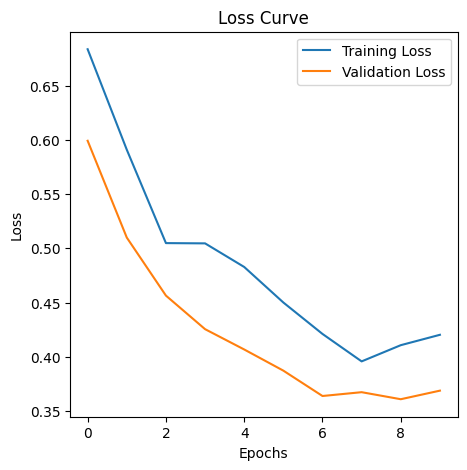

In [22]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plotted accuracy curves for training and validation sets

 As training is a stochastic process, the loss and accuracy graphs differs across runs. As long as the general trend shows decreasing loss and increasing accuracy, the model is improving.


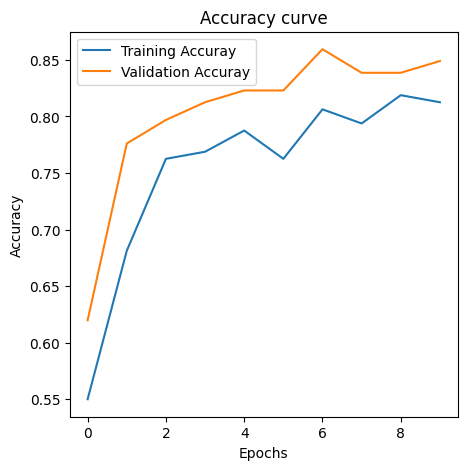

In [ ]:
import matplotlib.pyplot as plt

history = extract_feat_model
## Plotted accuracy curves for training and validation sets

plt.figure(figsize = (5,5))
plt.plot(history.history['accuracy'], label = 'Training Accuray')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuray')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



## Fine-Tuning the model

Fine-tuning improves the performance of the model. 

I've **unfreezed** the top 3 layers of the base model and trained the model again.


In [24]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
# We only want the useful extracted features, that's why include_top = False
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

# inbuilt function: Can render complex outputs, images, HTML, df's, plots
display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


As before, I've created a new model on top, and added Dropout layers for regularization.


In [25]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
lr: 9.048374180359596e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5129 - loss: 0.7281 
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 14s/step - accuracy: 0.5750 - loss: 0.6812 - val_accuracy: 0.8125 - val_loss: 0.5429 - learning_rate: 1.0000e-04
Epoch 2/10
lr: 8.187307530779819e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6399 - loss: 0.6378 
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.6500 - loss: 0.6152 - val_accuracy: 0.8021 - val_loss: 0.4880 - learning_rate: 9.0484e-05
Epoch 3/10
lr: 7.408182206817179e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8233 - loss: 0.4627 
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 15s/step - accuracy: 0.7937 - loss: 0.5083 - val_accuracy: 0.8385 - val_loss: 0.4327 - learning_rate: 8.1873e-05
Epoch 4/10
lr: 6.703200460356393e-05━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8012 - loss: 0.4233 
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 18s/step - accuracy: 0.8188 - loss: 0.4243 - val_accuracy: 0.8542 - val_loss: 0.3691 - learning_rate: 7.4082e-05
Epoch 5/10
lr: 6.065306597126335e-05━━━━━━━━━━━━ 0s 

### Plotted loss curves for training and validation sets (fine tuned model)

As always we focus on the general trend. If the general trend shows decreasing loss and increasing accuracy the model is performing well.

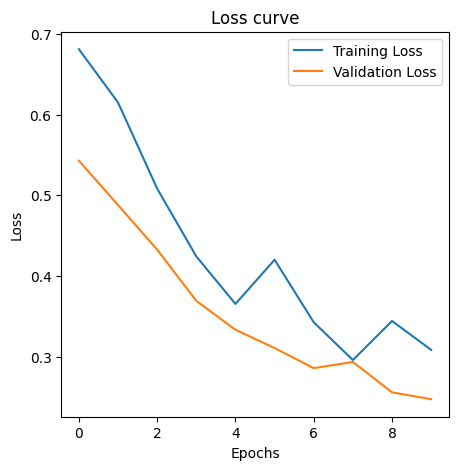

In [ ]:
history = fine_tune_model

## Plotted loss curves for training and validation sets (fine tune model)
plt.figure(figsize = (5, 5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotted accuracy curves for training and validation sets  (fine tuned model)

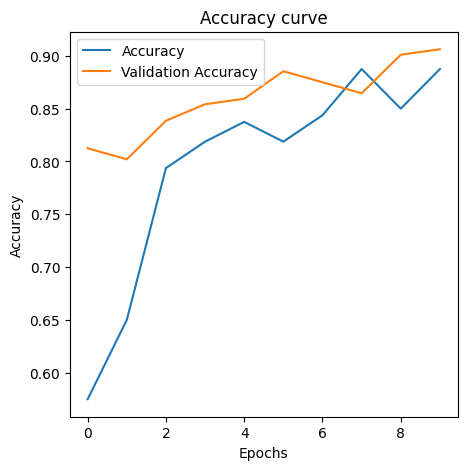

In [ ]:
history = fine_tune_model

plt.figure(figsize = (5, 5))
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Evaluated both models on test data

- Load saved models
- Load test images
- Make predictions for both models
- Convert predictions to class labels
- Print classification report for both models


In [29]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.78      0.78      0.78        50
           R       0.78      0.78      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.76      0.84      0.80        50
           R       0.82      0.74      0.78        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



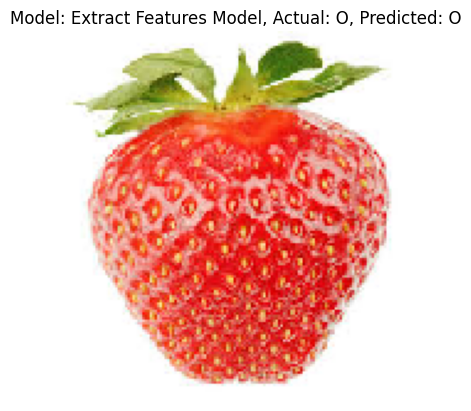

In [30]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

### Plotted a test image using Extract Features Model

Due to the inherent nature of neural networks, predictions sometimes vary from the actual labels. 

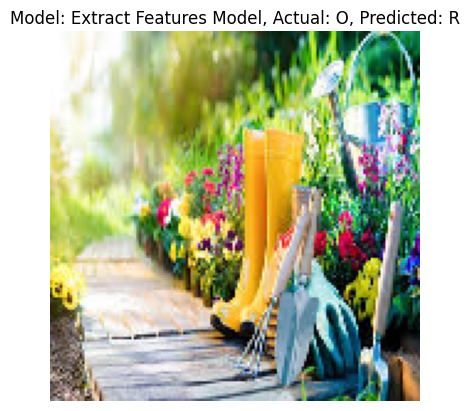

In [ ]:
# Plotted a test image using Extract Features Model (index_to_plot = 1)
index_to_plot = 1

plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

### Plotted a test image using Fine-Tuned Model

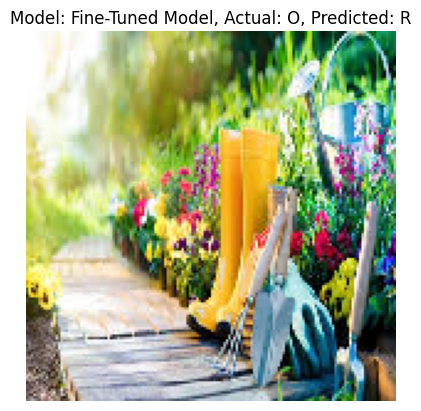

In [ ]:
# Plotted a test image using Fine-Tuned Model
index_to_plot = 1

plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )